#Movie Lens Collaborative Filtering Example (Single Core TPU)

<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/samples/MovieLensCollaborativeFilteringTPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qqq --no-cache-dir torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchtext==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 735.4MB 1.2MB/s 
     |████████████████████████████████| 12.8MB 28.9MB/s 
     |████████████████████████████████| 7.0MB 6.9MB/s 


In [ ]:
!pip install -Uqq fastcore --upgrade
!pip install -Uqq fastai --upgrade
!pip install -Uqq fastai_xla_extensions
# !pip install -Uqq git+https://github.com/butchland/fastai_xla_extensions.git

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 194kB 5.3MB/s 


In [ ]:
!curl -s https://course19.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:
!pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp37-cp37m-linux_x86_64.whl
# VERSION = "20200325" #@param ["1.5" , "20200707", "20200325", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py > /dev/null
# !python pytorch-xla-env-setup.py --version $VERSION > /dev/null

     |████████████████████████████████| 133.6MB 95kB/s 
     |████████████████████████████████| 61kB 2.6MB/s 
ERROR: earthengine-api 0.1.254 has requirement google-api-python-client>=1.12.1, but you'll have google-api-python-client 1.8.0 which is incompatible.


In [ ]:
!pip freeze | grep torch
!pip freeze | grep fast

torch==1.7.1+cu101
torch-xla==1.7
torchsummary==1.5.1
torchtext==0.8.0
torchvision==0.8.2+cu101
fastai==2.2.7
fastai-xla-extensions==0.0.8
fastcore==1.3.19
fastdtw==0.3.4
fastprogress==1.0.0
fastrlock==0.5


In [ ]:
from fastai.tabular.all import *
from fastai.collab import *
from fastai_xla_extensions.all import *

In [ ]:
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)

In [ ]:
ratings = ratings.merge(movies)

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.device

device(type='cpu')

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [ ]:
learn.to_xla()

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.954164,0.935667,00:43
1,0.855762,0.861252,00:41
2,0.744346,0.819212,00:40
3,0.612058,0.807533,00:40
4,0.484240,0.808535,00:39


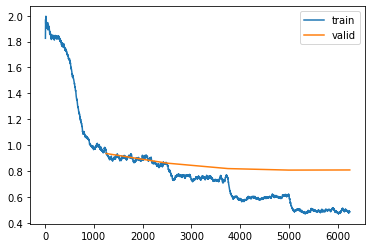

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.dls.device

device(type='xla', index=1)

In [ ]:
one_param(learn.model).device

device(type='xla', index=1)

### Interpretation

In [ ]:
g = ratings.groupby("title")['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

In [ ]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [ ]:
mean_ratings = ratings.groupby("title")['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [ ]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3708),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3188),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2943), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2715), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2601), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2501), 'Flintstones, The (1994)', 2.064516129032258),
 (tensor(-0.2388), 'Kansas City (1996)', 2.260869565217391),
 (tensor(-0.2302), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2224), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2193), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2148), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2080), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2061), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2040), 'Sgt. Bilko (1996)', 2.5675675675675675),
 (tensor(-0.2039), 'Island of Dr. Moreau, The (1996)', 2.157894736842